In [203]:
import numpy as np
from scipy.stats import multivariate_normal
from zappa_storehugs import zappa_sampling_store_hugs, project
from HugHop.StandardHugHop import HugHop
from Manifolds.RotatedEllipse import RotatedEllipse
from utils import logf_Jacobian
from utils import logp as logp_scale
from utils import quick_MVN_scatter, quick_MVN_marginals
import matplotlib.pyplot as plt
from numpy import zeros, log
from numpy.random import rand, randn
from utils import normalize
from math import degrees, radians

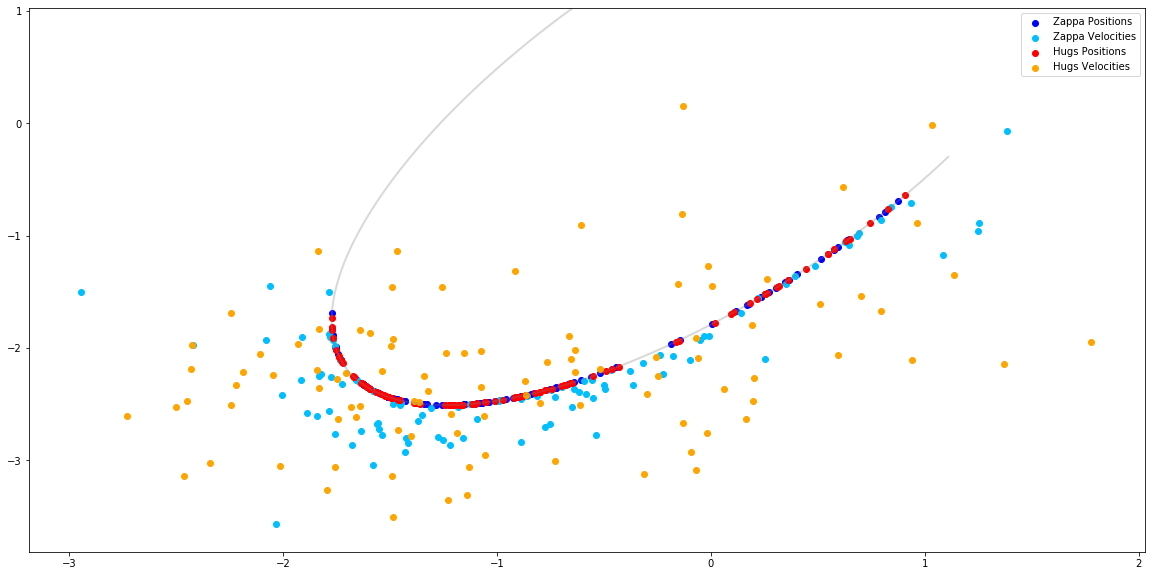

In [182]:
np.random.seed(11)
# Target
mu = np.zeros(2)
Sigma = np.array([[1.0, 0.99], [0.99, 2.0]])
target = multivariate_normal(mu, Sigma)
grad_log_pi = lambda xy: - np.linalg.inv(Sigma) @ xy

# Settings
x0 = target.rvs()     # Starting point
z0 = target.pdf(x0)
T = 0.1 
B = 5 
N = 50000
l = 2.0     
k = 1.0
# Settings for Zappa
s = 0.5
n = 100
tol=1.48e-08
a_guess = 1.0

# Symmetric Proposal Distribution for the Velocity (HUG)
q = multivariate_normal(np.zeros(2), (s**2)*np.eye(2))

# Corrected target
logf = lambda xy: logf_Jacobian(xy, Sigma)
logp = lambda xy: logp_scale(xy, sigma=s)

manifold = RotatedEllipse(mu, Sigma, z0)
HHObj = HugHop(T, B, x0, q, target.logpdf, grad_log_pi, l, k)
samples, vs, hugs, vshug, ashug = zappa_sampling_store_hugs(
    x0, manifold, logf, logp, n, s, tol, a_guess, HHObj
)

xvals = np.hstack((samples[:, 0], vs[:, 0], hugs[:, 0]))
xlims = (np.min(xvals)*1.1, np.max(xvals)*1.1)
yvals = np.hstack((samples[:, 1], vs[:, 1], hugs[:, 1]))
ylims = (np.min(yvals)*1.1, np.max(yvals)*1.1)
x, y = np.mgrid[xlims[0]:xlims[1]:.001, ylims[0]:ylims[1]:.001]
pos = np.dstack((x, y))

fig, ax = plt.subplots(figsize=(20,10))

# CONTOUR
ax.contour(x, y, target.pdf(pos), linewidths=2, levels=[z0], alpha=0.3, colors="gray") 

# ZAPPA POSITIONS
ax.scatter(*samples.T, label="Zappa Positions", color="blue")

# ZAPPA VELOCITIES
ax.scatter(*(samples[:-1] + vs).T, label="Zappa Velocities", color="deepskyblue")

# HUGS POSITIONS
ax.scatter(*(hugs[1:]).T, label="Hugs Positions", color="red")

# HUGS VELOCITIES
ax.scatter(*(vshug + hugs[1:]).T, label="Hugs Velocities", color="orange")

plt.legend()
plt.show()

# At once

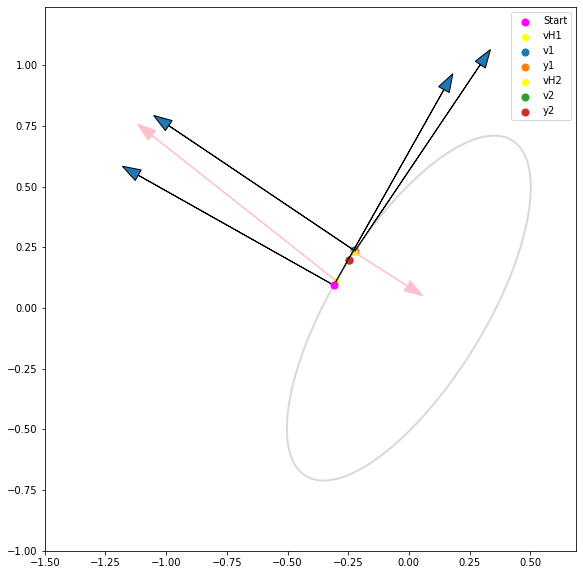

In [284]:
np.random.seed(4)

mu = np.zeros(2)
Sigma = np.array([[1.0, 0.99], [0.99, 2.0]])
target = multivariate_normal(mu, Sigma)
grad_log_pi = lambda xy: - np.linalg.inv(Sigma) @ xy

# Settings
x0 = target.rvs()     # Starting point
z0 = target.pdf(x0)
T = 0.1 
B = 5 
l = 2.0     
k = 1.0
# Settings for Zappa
s = 0.5
sigma = s
n = 3
tol=1.48e-08
a_guess = 1.0

###########################################
xlims=(-1.5, 0.7)
ylims=(-1, 1.25)
x, y = np.mgrid[xlims[0]:xlims[1]:.01, ylims[0]:ylims[1]:.01]
pos = np.dstack((x, y))
fig, ax = plt.subplots(figsize=(20, 10))
ax.contour(x, y, target.pdf(pos), linewidths=2, levels=[z0], alpha=0.3, colors="gray") 
###########################################

# Symmetric Proposal Distribution for the Velocity (HUG)
q = multivariate_normal(np.zeros(2), (s**2)*np.eye(2))

logf = lambda xy: logf_Jacobian(xy, Sigma)
logp = lambda xy: logp_scale(xy, sigma=s)

manifold = RotatedEllipse(mu, Sigma, z0)
HHObj = HugHop(T, B, x0, q, target.logpdf, grad_log_pi, l, k)

n = int(n)
d, m = manifold.get_dimension(), manifold.get_codimension()

# Initial point on the manifold
x = x0
#######################
ax.scatter(*x0, color="magenta", zorder=100, s=50, label="Start")
######################

# Samples House-keeping
samples = zeros((n, d + m))    # Store n samples on the manifold
samples[0, :] = x
i = 1

# Velocities Housekeeping
vs = zeros((n - 1, d + m))

# Hug and Hop Housekeeping
hugs = zeros((n, d + m))    # Stores where Hug Kernel proposes
hugs[0, :] = x
vshug = zeros((n - 1, d + m))    # Stores velocity at proposal point
ashug = zeros(n - 1)            # Stores flags for accept/reject

# Log-uniforms for MH accept-reject step
logu = log(rand(n))

# Run until you get n samples
while i < n:
    # Hug Kernel
    xhug, vhug, ahug = HHObj.HugKernel(x)
    hugs[i, :] = xhug
    vshug[i-1, :] = vhug
    ashug[i - 1] = ahug
    ###################################
    ax.scatter(*xhug, label="vH{}".format(i), color="yellow")
    ax.arrow(*xhug, *(vhug+xhug), label="xH{}".format(i), color="pink",  length_includes_head=True, head_width=0.05)
    ###################################
    # Compute gradient, gradient basis & tangent basis at x
    Qx = manifold.Q(x)                       # Gradient at x.                             Size: (d + m, )
    gx_basis = normalize(Qx)                 # ON basis for gradient at x                 Size: (d + m, )
    tx_basis = manifold.tangent_basis(Qx) # ON basis for tangent space at x using SVD  Size: (d + m, d)
    ###########################
    
    ax.arrow(*x, *gx_basis.flatten(), length_includes_head=True, head_width=0.05) #############
    ax.arrow(*x, *tx_basis.flatten(), length_includes_head=True, head_width=0.05) #############
    ##############################
    
    # Sample along tangent 
    v_sample = sigma*randn(d)  # Isotropic MVN with scaling sigma         Size: (d, )
    v = tx_basis @ v_sample    # Linear combination of the basis vectors  Size: (d + m, )
    ###########################
    ax.scatter(*(x+v), label="v{}".format(i), s=50)
    ###########################

    # Forward Projection
    a, flag = project(x, v, Qx, manifold.q, tol, a_guess)
    if flag == 0:                                  # Projection failed
        samples[i, :] = x                          # Stay at x
        vs[i-1, :] = v                             # Store velocity
        i += 1
        continue
    y = x + v + a*Qx.flatten()                              # Projected point (d + m, )
    ########################
    ax.scatter(*y, label="y{}".format(i), s=50)
    ########################

    # Compute v' from y
    Qy = manifold.Q(y)                         # Gradient at y.                            Size: (d + m, )
    gy_basis = normalize(Qy)             # ON basis for gradient at y                Size: (d + m, )
    ty_basis = manifold.tangent_basis(Qy)      # ON basis for tangent space at y using SVD Size: (d + m, d)
    v_prime_sample = (x - y) @ ty_basis  # Components along tangent                  Size: (d + m, )

    # Metropolis-Hastings
    if logu[i] > logf(y) + logp(v_prime_sample) - logf(x) - logp(v_sample):
        samples[i, :] = x     # Reject. Stay at x
        vs[i-1, :] = v        # Store velocity
        i += 1
        continue

    # Backward Projection
    v_prime = v_prime_sample @ ty_basis.T   # Linear combination of the basis vectors. Size: (d + m, )
    a_prime, flag = project(y, v_prime, Qy, manifold.q, tol, a_guess)
    if flag == 0:
        samples[i, :] = x     # projection failed, stay at x
        vs[i-1, :] = v        # store velocity
        i += 1
        continue

    # Store velocity (i-1 because we didn't have any initial velocity)
    vs[i-1, :] = v_prime

    # Accept move
    x = y
    samples[i, :] = x
    i += 1
    
#ax.set_xlim(-1, 1)
#ax.set_ylim(-0.05, -0.03)
ax.set_aspect('equal')
plt.legend()
plt.show()

# Plot Ellipse and gradients

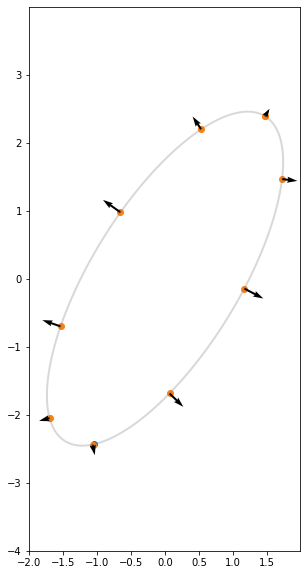

In [239]:
# Target
mu = np.zeros(2)
Sigma = np.array([[1.0, 0.99], [0.99, 2.0]])
target = multivariate_normal(mu, Sigma)

# Points on manifold
np.random.seed(1)
x0 = target.rvs()
z0 = target.pdf(x0)
manifold = RotatedEllipse(mu, Sigma, z0)
points = np.vstack([manifold.to_cartesian(t) for t in np.linspace(0, 2*np.pi, num=10)])

# Gradient basis
gx_basis = normalize(manifold.Q(x0))
grads = np.vstack([manifold.Q(point).flatten() for point in points])

# Plotting params
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(*x0)
ax.scatter(*points.T)
#ax.quiver(*x0, *gx_basis, color="red")
ax.quiver(*points.T, *grads.T)
#ax.arrow(x0[0], x0[1], )

# Contour
xlims=(-2, 2)
ylims=(-4, 4)
x, y = np.mgrid[xlims[0]:xlims[1]:.01, ylims[0]:ylims[1]:.01]
pos = np.dstack((x, y))
ax.contour(x, y, target.pdf(pos), linewidths=2, levels=[z0], alpha=0.3, colors="gray") 
ax.set_aspect("equal")
plt.show()

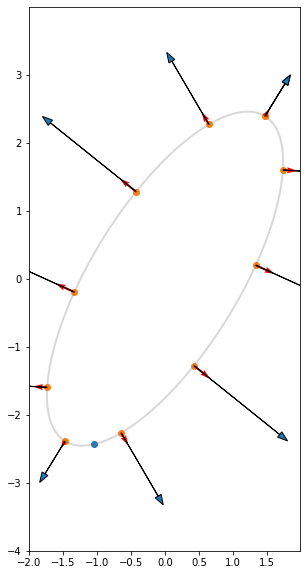

In [244]:
# Target
mu = np.zeros(2)
Sigma = np.array([[1.0, 0.99], [0.99, 2.0]])
target = multivariate_normal(mu, Sigma)

# Points on manifold
np.random.seed(1)
x0 = target.rvs()
z0 = target.pdf(x0)
manifold = RotatedEllipse(mu, Sigma, z0)
points = np.vstack([manifold.to_cartesian(t) for t in np.linspace(0, 2*np.pi, num=11)])

# Gradient basis
gx_basis = normalize(manifold.Q(x0))
grads = np.vstack([manifold.Q(point).flatten() for point in points])

# Plotting params
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(*x0)
ax.scatter(*points.T)
#ax.quiver(*x0, *gx_basis, color="red")
for (point, grad) in zip(points, grads):
    ax.arrow(*point, *grad, length_includes_head=True, head_width=0.1)
ax.quiver(*points.T, *grads.T, color="red")
#ax.arrow(x0[0], x0[1], )

# Contour
xlims=(-2, 2)
ylims=(-4, 4)
x, y = np.mgrid[xlims[0]:xlims[1]:.01, ylims[0]:ylims[1]:.01]
pos = np.dstack((x, y))
ax.contour(x, y, target.pdf(pos), linewidths=2, levels=[z0], alpha=0.3, colors="gray") 
ax.set_aspect("equal")
plt.show()